<font size=5 >Set up</font>

In [1]:
import h5py as h5 
import matplotlib.pyplot as plt
import numpy as np 
import gvar as gv  
import lsqfit as lsf
import math
import os 
import hashlib
os.chdir(os.getcwd() + '/my_project') # put this file and 'my_project' in a same folder # if you do not use database, delete this line

from my_project.formfactor_fit.models import T2K_fit as formfactor_fit_T2K_fit
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true" # for jupyter to use database


In [2]:
from module.plot import Plot
from module.prior_setting import prior

<font size=5 >Class and function</font>

In [3]:
class Prepare_data():
    def __init__(self, file_name, file_path, fh_file_path, pt2_data_range, pt3_data_range):
        self.file_name = file_name
        self.file_path = file_path
        self.fh_file_path = fh_file_path
        self.pt2_data_range = pt2_data_range
        self.pt3_data_range = pt3_data_range

    def rotate(self, lis, n): # used to rotate the list
        return lis[n:] + lis[:n]

    def find_key(self, part_of_file, name_of_key): # find the keys that named with specific string in the dictionary 
        i = 0
        list_of_key = []
        for key in part_of_file:
            if name_of_key in key:
                list_of_key.append(key)
                i += 1

        if self.pt3_data_range[1] > 10:
            list_of_key = self.rotate(list_of_key, self.pt3_data_range[1]-10)

        return list_of_key

    def read_data_with_average(self):
        myfile = h5.File(self.file_path,'r')

        two_point_ml0p0126 = myfile['gf1p0_w3p0_n30_M51p2_L58_a1p5']['spec']['ml0p0126'] # different data file need different path here

        two_point_proton = np.array([two_point_ml0p0126['proton']['px0_py0_pz0']['spin_dn'][:],
        two_point_ml0p0126['proton']['px0_py0_pz0']['spin_up'][:]])
        two_point_proton_np = np.array([two_point_ml0p0126['proton_np']['px0_py0_pz0']['spin_dn'][:],
        two_point_ml0p0126['proton_np']['px0_py0_pz0']['spin_up'][:]])
        
        two_point_data = (two_point_proton[0] + two_point_proton[1] + two_point_proton_np[0] + two_point_proton_np[1])/4
        two_point_data = np.squeeze(two_point_data)

        three_point_ml0p0126 = myfile['gf1p0_w3p0_n30_M51p2_L58_a1p5']['formfac']['ml0p0126']

        proton_DD_dn_dn = self.find_key(three_point_ml0p0126, 'proton_DD_dn_dn')
        proton_DD_up_up = self.find_key(three_point_ml0p0126, 'proton_DD_up_up')
        proton_np_DD_dn_dn = self.find_key(three_point_ml0p0126, 'proton_np_DD_dn_dn')
        proton_np_DD_up_up = self.find_key(three_point_ml0p0126, 'proton_np_DD_up_up')

        proton_UU_dn_dn = self.find_key(three_point_ml0p0126, 'proton_UU_dn_dn')
        proton_UU_up_up = self.find_key(three_point_ml0p0126, 'proton_UU_up_up')
        proton_np_UU_dn_dn = self.find_key(three_point_ml0p0126, 'proton_np_UU_dn_dn')
        proton_np_UU_up_up = self.find_key(three_point_ml0p0126, 'proton_np_UU_up_up')

        data_dict = {}

        for i in range(len(two_point_data[0])):
            data_dict['pt2_tsep_' + str(i)] = two_point_data[:, i, 0] # 2pt ss data
            data_dict['pt2_ps_tsep_' + str(i)] = two_point_data[:, i, 1] # 2pt ps data

            ## shape = (1053,)

        for i in range(self.pt3_data_range[0], self.pt3_data_range[1]): # average
            data_dict['pt3_A3_tsep_' + str(i)] = (np.imag(three_point_ml0p0126[proton_UU_up_up[i-self.pt3_data_range[0]]]['A3']['px0_py0_pz0']['local_curr'][:] \
                - three_point_ml0p0126[proton_DD_up_up[i-self.pt3_data_range[0]]]['A3']['px0_py0_pz0']['local_curr'][:]) \
                    -np.imag(three_point_ml0p0126[proton_UU_dn_dn[i-self.pt3_data_range[0]]]['A3']['px0_py0_pz0']['local_curr'][:] \
                        - three_point_ml0p0126[proton_DD_dn_dn[i-self.pt3_data_range[0]]]['A3']['px0_py0_pz0']['local_curr'][:]) \
                            + np.imag(three_point_ml0p0126[proton_np_UU_dn_dn[i-self.pt3_data_range[0]]]['A3']['px0_py0_pz0']['local_curr'][:] \
                                - three_point_ml0p0126[proton_np_DD_dn_dn[i-self.pt3_data_range[0]]]['A3']['px0_py0_pz0']['local_curr'][:]) \
                                    - np.imag(three_point_ml0p0126[proton_np_UU_up_up[i-self.pt3_data_range[0]]]['A3']['px0_py0_pz0']['local_curr'][:] \
                                        - three_point_ml0p0126[proton_np_DD_up_up[i-self.pt3_data_range[0]]]['A3']['px0_py0_pz0']['local_curr'][:]))/4

            data_dict['pt3_V4_tsep_' + str(i)] = (np.real(three_point_ml0p0126[proton_UU_up_up[i-self.pt3_data_range[0]]]['V4']['px0_py0_pz0']['local_curr'][:] \
                - three_point_ml0p0126[proton_DD_up_up[i-self.pt3_data_range[0]]]['V4']['px0_py0_pz0']['local_curr'][:]) \
                    + np.real(three_point_ml0p0126[proton_UU_dn_dn[i-self.pt3_data_range[0]]]['V4']['px0_py0_pz0']['local_curr'][:] \
                        - three_point_ml0p0126[proton_DD_dn_dn[i-self.pt3_data_range[0]]]['V4']['px0_py0_pz0']['local_curr'][:]) \
                            - np.real(three_point_ml0p0126[proton_np_UU_dn_dn[i-self.pt3_data_range[0]]]['V4']['px0_py0_pz0']['local_curr'][:] \
                                - three_point_ml0p0126[proton_np_DD_dn_dn[i-self.pt3_data_range[0]]]['V4']['px0_py0_pz0']['local_curr'][:]) \
                                    - np.real(three_point_ml0p0126[proton_np_UU_up_up[i-self.pt3_data_range[0]]]['V4']['px0_py0_pz0']['local_curr'][:] \
                                        - three_point_ml0p0126[proton_np_DD_up_up[i-self.pt3_data_range[0]]]['V4']['px0_py0_pz0']['local_curr'][:]))/4

            ## shape = (1053, 64)
            
        fh_file = h5.File(fh_file_path,'r')['a12m310'] # read the fh data
        gA_ps = fh_file['ga_ps']
        gA_ss = fh_file['ga_ss']
        gV_ps = fh_file['gv_ps']
        gV_ss = fh_file['gv_ss']
        
        for i in range(len(gA_ps[0])):
            data_dict['fh_gA_ps_tsep_' + str(i)] = gA_ps[:, i]
            data_dict['fh_gA_ss_tsep_' + str(i)] = gA_ss[:, i]
            data_dict['fh_gV_ps_tsep_' + str(i)] = gV_ps[:, i]
            data_dict['fh_gV_ss_tsep_' + str(i)] = gV_ss[:, i]

        data_avg_dict = gv.dataset.avg_data(data_dict)
        
        for i in range(len(gA_ps[0])): # seems Jason forgot to divided by 4 when averaging the fh data
            data_avg_dict['fh_gA_ps_tsep_' + str(i)] = data_avg_dict['fh_gA_ps_tsep_' + str(i)]/4
            data_avg_dict['fh_gA_ss_tsep_' + str(i)] = data_avg_dict['fh_gA_ss_tsep_' + str(i)]/4
            data_avg_dict['fh_gV_ps_tsep_' + str(i)] = data_avg_dict['fh_gV_ps_tsep_' + str(i)]/4
            data_avg_dict['fh_gV_ss_tsep_' + str(i)] = data_avg_dict['fh_gV_ss_tsep_' + str(i)]/4

        return data_avg_dict


    def add_sum_data(self, data_avg_dict, sum_tau_cut):
        for i in range(self.pt3_data_range[0], self.pt3_data_range[1]):
            data_avg_dict['sum_A3_tsep_' + str(i)] = gv.gvar(0, 0)
            data_avg_dict['sum_V4_tsep_' + str(i)] = gv.gvar(0, 0)

            for j in range(sum_tau_cut, i-sum_tau_cut+1): # do the summation
                if i-sum_tau_cut+1 <= sum_tau_cut:
                    print('cut error')
                data_avg_dict['sum_A3_tsep_' + str(i)] += data_avg_dict['pt3_A3_tsep_' + str(i)][j]
                data_avg_dict['sum_V4_tsep_' + str(i)] += data_avg_dict['pt3_V4_tsep_' + str(i)][j]

        for i in range(self.pt3_data_range[0], self.pt3_data_range[1]-1): # use ratio form to do the fit
            # fit_12 will use tsep_13 here, so the tsep range of sum part should not be bigger than 11
            data_avg_dict['sum_A3_fit_'+str(i)] = (data_avg_dict['sum_A3_tsep_' + str(i+1)]/data_avg_dict['pt2_tsep_'+str(i+1)]) - (data_avg_dict['sum_A3_tsep_' + str(i)]/data_avg_dict['pt2_tsep_'+str(i)])

            data_avg_dict['sum_V4_fit_'+str(i)] = (data_avg_dict['sum_V4_tsep_' + str(i+1)]/data_avg_dict['pt2_tsep_'+str(i+1)]) - (data_avg_dict['sum_V4_tsep_' + str(i)]/data_avg_dict['pt2_tsep_'+str(i)])

        return data_avg_dict
    
    
    def add_fh_data(self, data_avg_dict): # use ratio form to do the fit
        for i in range(self.pt2_data_range[0], self.pt2_data_range[1]-1): # fh data have the same range as 2pt data
            data_avg_dict['fh_ps_A3_fit_'+str(i)] = (data_avg_dict['fh_gA_ps_tsep_' + str(i+1)]/data_avg_dict['pt2_ps_tsep_'+str(i+1)]) - (data_avg_dict['fh_gA_ps_tsep_' + str(i)]/data_avg_dict['pt2_ps_tsep_'+str(i)])

            data_avg_dict['fh_ps_V4_fit_'+str(i)] = (data_avg_dict['fh_gV_ps_tsep_' + str(i+1)]/data_avg_dict['pt2_ps_tsep_'+str(i+1)]) - (data_avg_dict['fh_gV_ps_tsep_' + str(i)]/data_avg_dict['pt2_ps_tsep_'+str(i)])
            
            data_avg_dict['fh_ss_A3_fit_'+str(i)] = (data_avg_dict['fh_gA_ss_tsep_' + str(i+1)]/data_avg_dict['pt2_tsep_'+str(i+1)]) - (data_avg_dict['fh_gA_ss_tsep_' + str(i)]/data_avg_dict['pt2_tsep_'+str(i)])

            data_avg_dict['fh_ss_V4_fit_'+str(i)] = (data_avg_dict['fh_gV_ss_tsep_' + str(i+1)]/data_avg_dict['pt2_tsep_'+str(i+1)]) - (data_avg_dict['fh_gV_ss_tsep_' + str(i)]/data_avg_dict['pt2_tsep_'+str(i)])

        return data_avg_dict
        

In [4]:
class Fit():
    def __init__(self, file_name, fh_file_name, data_avg_dict_completed, pt2_nstates, pt2_t_range, pt2_ps_t_range, pt3_nstates, pt3_A3_tsep_range, pt3_V4_tsep_range, pt3_tau_cut, sum_nstates,sum_A3_tsep_range, sum_V4_tsep_range, sum_tau_cut, fh_nstates, fh_ss_A3_tsep_range, fh_ss_V4_tsep_range, fh_ps_A3_tsep_range, fh_ps_V4_tsep_range, include_2pt, include_2pt_ps, include_3pt, include_sum, include_fh_ss, include_fh_ps, chained):
        self.file_name = file_name
        self.fh_file_name = fh_file_name
        self.data_avg_dict = data_avg_dict_completed
        
        self.pt2_nstates = pt2_nstates
        self.pt2_t_range = pt2_t_range
        
        self.pt2_ps_t_range = pt2_ps_t_range
        
        self.pt3_nstates = pt3_nstates
        self.pt3_A3_tsep_range = pt3_A3_tsep_range
        self.pt3_V4_tsep_range = pt3_V4_tsep_range
        self.pt3_tau_cut = pt3_tau_cut
        
        self.sum_nstates = sum_nstates
        self.sum_A3_tsep_range = sum_A3_tsep_range
        self.sum_V4_tsep_range = sum_V4_tsep_range
        self.sum_tau_cut = sum_tau_cut
        
        self.fh_nstates = fh_nstates
        
        self.fh_ss_A3_tsep_range = fh_ss_A3_tsep_range
        self.fh_ss_V4_tsep_range = fh_ss_V4_tsep_range
        
        self.fh_ps_A3_tsep_range = fh_ps_A3_tsep_range
        self.fh_ps_V4_tsep_range = fh_ps_V4_tsep_range
        
        self.include_2pt = include_2pt
        self.include_2pt_ps = include_2pt_ps
        self.include_3pt = include_3pt
        self.include_sum = include_sum
        self.include_fh_ss = include_fh_ss
        self.include_fh_ps = include_fh_ps
        
        self.chained = chained
        
        nstate_array = np.array([self.pt2_nstates, self.pt2_nstates, self.pt3_nstates, self.sum_nstates, self.fh_nstates])
        max_nstate = max(nstate_array)
        
        self.prior = prior(max_nstate, self.pt3_nstates, self.sum_nstates, self.fh_nstates)

    def pt2_fit_function(self, pt2_t, p):
        E_list = {}
        for i in range(self.pt2_nstates): #initialize       
            E_list['E'+str(i)] = p['E0']

        for i in range(1, self.pt2_nstates): #define Ei      
            for j in range(1, i+1):
                    E_list['E'+str(i)] += p['dE'+str(j)]

        val = {}

        val['pt2'] = p['z0']*p['z0']*np.exp(-E_list['E0']*pt2_t)

        for i in range(1, self.pt2_nstates):
            val['pt2'] += p['z'+str(i)]*p['z'+str(i)]*np.exp(-E_list['E'+str(i)]*pt2_t)

        return val
    
    def pt2_ps_fit_function(self, pt2_ps_t, p):
        E_list = {}
        for i in range(self.pt2_nstates): #initialize       
            E_list['E'+str(i)] = p['E0']

        for i in range(1, self.pt2_nstates): #define Ei      
            for j in range(1, i+1):
                    E_list['E'+str(i)] += p['dE'+str(j)]

        val = {}

        val['pt2_ps'] = p['z0_ps']*p['z0_ps']*np.exp(-E_list['E0']*pt2_ps_t)

        for i in range(1, self.pt2_nstates):
            val['pt2_ps'] += p['z'+str(i)+'_ps']*p['z'+str(i)+'_ps']*np.exp(-E_list['E'+str(i)]*pt2_ps_t)

        return val
        

    def pt3_fit_function(self, pt3_tsep_A3, pt3_tsep_V4, pt3_tau_A3, pt3_tau_V4, p):
        E_list = {}
        for i in range(self.pt3_nstates): #initialize       
            E_list['E'+str(i)] = p['E0']

        for i in range(1, self.pt3_nstates): #define Ei      
            for j in range(1, i+1):
                    E_list['E'+str(i)] += p['dE'+str(j)]

        val = {}

        val['pt3_A3'] = p['A3_00']*p['z0']*p['z0']*np.exp(-E_list['E0']*pt3_tsep_A3) 

        val['pt3_V4'] = p['V4_00']*p['z0']*p['z0']*np.exp(-E_list['E0']*pt3_tsep_V4) 

        for i in range(self.pt3_nstates):    
            for j in range(self.pt3_nstates):
                if i+j >= 1:
                    if j == i:
                        val['pt3_A3'] += p['A3_'+str(j)+str(i)]*p['z'+str(j)]*p['z'+str(i)]*np.exp(-E_list['E'+str(j)]*pt3_tsep_A3)

                        val['pt3_V4'] += p['V4_'+str(j)+str(i)]*p['z'+str(j)]*p['z'+str(i)]*np.exp(-E_list['E'+str(j)]*pt3_tsep_V4)

                    else:
                        mi = np.minimum(j, i)
                        ma = np.maximum(j, i)
                        val['pt3_A3'] += p['A3_'+str(mi)+str(ma)]*p['z'+str(j)]*p['z'+str(i)]*np.exp(-E_list['E'+str(j)]*pt3_tsep_A3)*np.exp((E_list['E'+str(j)]-E_list['E'+str(i)])*pt3_tau_A3)

                        val['pt3_V4'] += p['V4_'+str(mi)+str(ma)]*p['z'+str(j)]*p['z'+str(i)]*np.exp(-E_list['E'+str(j)]*pt3_tsep_V4)*np.exp((E_list['E'+str(j)]-E_list['E'+str(i)])*pt3_tau_V4)

        return val

    def summation(self, A3_t, V4_t, p):
        E_list = {}
        for i in range(self.sum_nstates): #initialize       
            E_list['E'+str(i)] = p['E0']

        for i in range(1, self.sum_nstates): #define Ei      
            for j in range(1, i+1):
                    E_list['E'+str(i)] += p['dE'+str(j)]

        if self.sum_nstates == 1:
            cut = self.sum_tau_cut

            val = {}

            val['sum_A3'] = p['z0'] * p['A3_00'] * p['z0'] * np.exp(-E_list['E0'] * A3_t) * (A3_t - 2*cut + 1)

            val['sum_V4'] = p['z0'] * p['V4_00'] * p['z0'] * np.exp(-E_list['E0'] * V4_t) * (V4_t - 2*cut + 1)

            return val

        #E_list['E_sum'] = E_list['E'+ str(self.sum_nstates - 2)] + p['E_sum']
        E_list['E_sum'] = E_list['E'+ str(self.sum_nstates - 2)] + p['E_fh'] # same garbage can for sum and fh

        E = np.zeros([self.sum_nstates-1], dtype=gv.GVar)
        z = np.zeros([self.sum_nstates-1], dtype=gv.GVar)
        for i in range(self.sum_nstates-1):
            E[i] = E_list['E'+str(i)]
            z[i] = p['z'+str(i)]

        E_sum = E_list['E_sum']
        z_sum = p['z_fh_ss']

        D = np.zeros([self.sum_nstates-1, self.sum_nstates-1], dtype=gv.GVar)
        for i in range(self.sum_nstates-1):
            for j in range(self.sum_nstates-1):
                D[i][j] = E[i] - E[j]
        
        A3 = np.zeros([self.sum_nstates-1, self.sum_nstates-1], dtype=gv.GVar)
        V4 = np.zeros([self.sum_nstates-1, self.sum_nstates-1], dtype=gv.GVar)
        sumA3 = np.zeros([self.sum_nstates], dtype=gv.GVar)
        sumV4 = np.zeros([self.sum_nstates], dtype=gv.GVar)
        for i in range(self.sum_nstates-1):
            for j in range(self.sum_nstates-1):
                mi = np.minimum(j, i)
                ma = np.maximum(j, i)
                A3[i][j] = p['A3_'+str(mi)+str(ma)]
                V4[i][j] = p['V4_'+str(mi)+str(ma)]

        for i in range(self.sum_nstates):
            #sumA3[i] = p['sumA3_'+str(i)]
            #sumV4[i] = p['sumV4_'+str(i)]
            sumA3[i] = p['fh_A3_'+str(i)] # same garbage can for sum and fh
            sumV4[i] = p['fh_V4_'+str(i)]

        cut = self.sum_tau_cut

        val = {}

        val['sum_A3'] = z[0] * A3[0][0] * z[0] * np.exp(-E[0] * A3_t) * (A3_t - 2*cut + 1)

        val['sum_V4'] = z[0] * V4[0][0] * z[0] * np.exp(-E[0] * V4_t) * (V4_t - 2*cut + 1)


        for i in range(self.sum_nstates-1):
            for j in range(self.sum_nstates-1):
                if i+j >= 1:
                    if j == i: 
                        val['sum_A3'] += z[j] * A3[j][i] * z[i] * np.exp(-E[j] * A3_t) * (A3_t - 2*cut + 1)

                        val['sum_V4'] += z[j] * V4[j][i] * z[i] * np.exp(-E[j] * V4_t) * (V4_t - 2*cut + 1) 

                    else:
                        val['sum_A3'] += z[j] * A3[j][i] * z[i] * np.exp(-E[j] * A3_t) * ((np.exp(cut * D[j][i]) * (1 - np.exp((A3_t - 2*cut + 1) * D[j][i]) )) / (1 - np.exp(D[j][i]) ))

                        val['sum_V4'] += z[j] * V4[j][i] * z[i] * np.exp(-E[j] * V4_t) * ((np.exp(cut * D[j][i]) * (1 - np.exp((V4_t - 2*cut + 1) * D[j][i]) )) / (1 - np.exp(D[j][i]) ))

        for i in range(self.sum_nstates-1):
            val['sum_A3'] += z_sum * sumA3[i] * z[i] * np.exp(-E_sum * A3_t) * (((np.exp(cut * (E_sum - E[i])) ) * (1 - np.exp((A3_t - 2*cut + 1) * (E_sum - E[i])) )) / (1 - np.exp(E_sum - E[i]) ))

            val['sum_A3'] += z[i] * sumA3[i] * z_sum * np.exp(-E[i] * A3_t) * (((np.exp(cut * (E[i] - E_sum)) ) * (1 - np.exp((A3_t - 2*cut + 1) * (E[i] - E_sum)) )) / (1 - np.exp(E[i] - E_sum) ))

            val['sum_V4'] += z_sum * sumV4[i] * z[i] * np.exp(-E_sum * V4_t) * (((np.exp(cut * (E_sum - E[i])) ) * (1 - np.exp((V4_t - 2*cut + 1) * (E_sum - E[i])) )) / (1 - np.exp(E_sum - E[i]) ))

            val['sum_V4'] += z[i] * sumV4[i] * z_sum * np.exp(-E[i] * V4_t) * (((np.exp(cut * (E[i] - E_sum)) ) * (1 - np.exp((V4_t - 2*cut + 1) * (E[i] - E_sum)) )) / (1 - np.exp(E[i] - E_sum) ))

        val['sum_A3'] += z_sum * sumA3[self.sum_nstates-1] * z_sum * np.exp(-E_sum * A3_t) * (A3_t - 2*cut + 1)

        val['sum_V4'] += z_sum * sumV4[self.sum_nstates-1] * z_sum * np.exp(-E_sum * V4_t) * (V4_t - 2*cut + 1)

        return val 
    
    def fh_ss_fit_function(self, A3_t, V4_t, p):
        E_list = {}
        for i in range(self.fh_nstates): #initialize       
            E_list['E'+str(i)] = p['E0']

        for i in range(1, self.fh_nstates): #define Ei      
            for j in range(1, i+1):
                    E_list['E'+str(i)] += p['dE'+str(j)]

        if self.fh_nstates == 1:
            cut = 1 ## fh data has default value that tau cut = 1

            val = {}

            val['fh_ss_A3'] = (p['z0'] * p['A3_00'] * p['z0'] * (A3_t - 2*cut + 1) + p['d0_ss_A3']) * np.exp(-E_list['E0'] * A3_t)

            val['fh_ss_V4'] = (p['z0'] * p['V4_00'] * p['z0'] * (V4_t - 2*cut + 1) + p['d0_ss_V4']) * np.exp(-E_list['E0'] * V4_t)

            return val

        E_list['E_fh_ss'] = E_list['E'+ str(self.fh_nstates - 2)] + p['E_fh'] # same garbage of E for ss and ps

        E = np.zeros([self.fh_nstates-1], dtype=gv.GVar)
        z = np.zeros([self.fh_nstates-1], dtype=gv.GVar)
        
        for i in range(self.fh_nstates-1):
            E[i] = E_list['E'+str(i)]
            z[i] = p['z'+str(i)]

        E_fh = E_list['E_fh_ss']
        z_fh = p['z_fh_ss']

        D = np.zeros([self.fh_nstates-1, self.fh_nstates-1], dtype=gv.GVar)
        for i in range(self.fh_nstates-1):
            for j in range(self.fh_nstates-1):
                D[i][j] = E[i] - E[j]
        
        A3 = np.zeros([self.fh_nstates-1, self.fh_nstates-1], dtype=gv.GVar)
        V4 = np.zeros([self.fh_nstates-1, self.fh_nstates-1], dtype=gv.GVar)
        fhA3 = np.zeros([self.fh_nstates], dtype=gv.GVar)
        fhV4 = np.zeros([self.fh_nstates], dtype=gv.GVar)
        dA3 = np.zeros([self.fh_nstates], dtype=gv.GVar)
        dV4 = np.zeros([self.fh_nstates], dtype=gv.GVar)
        
        for i in range(self.fh_nstates-1):
            for j in range(self.fh_nstates-1):
                mi = np.minimum(j, i)
                ma = np.maximum(j, i)
                A3[i][j] = p['A3_'+str(mi)+str(ma)]
                V4[i][j] = p['V4_'+str(mi)+str(ma)]

        for i in range(self.fh_nstates): # same garbage of gA/gV for ss and ps
            fhA3[i] = p['fh_A3_'+str(i)]
            fhV4[i] = p['fh_V4_'+str(i)]
            dA3[i] = p['d'+str(i)+'_ss_A3']
            dV4[i] = p['d'+str(i)+'_ss_V4']
            

        cut = 1 ## fh data has default value that tau cut = 1

        val = {}

        val['fh_ss_A3'] = (z[0] * A3[0][0] * z[0] * (A3_t - 2*cut + 1) + dA3[0]) * np.exp(-E[0] * A3_t)

        val['fh_ss_V4'] = (z[0] * V4[0][0] * z[0] * (V4_t - 2*cut + 1) + dV4[0]) * np.exp(-E[0] * V4_t)


        for i in range(self.fh_nstates-1):
            for j in range(self.fh_nstates-1):
                if i+j >= 1:
                    if j == i: 
                        val['fh_ss_A3'] += (z[j] * A3[j][i] * z[i] * (A3_t - 2*cut + 1) + dA3[j]) * np.exp(-E[j] * A3_t)

                        val['fh_ss_V4'] += (z[j] * V4[j][i] * z[i] * (V4_t - 2*cut + 1) + dV4[j]) * np.exp(-E[j] * V4_t) 

                    else:
                        val['fh_ss_A3'] += z[j] * A3[j][i] * z[i] * np.exp(-E[j] * A3_t) * ((np.exp(cut * D[j][i]) * (1 - np.exp((A3_t - 2*cut + 1) * D[j][i]) )) / (1 - np.exp(D[j][i]) ))

                        val['fh_ss_V4'] += z[j] * V4[j][i] * z[i] * np.exp(-E[j] * V4_t) * ((np.exp(cut * D[j][i]) * (1 - np.exp((V4_t - 2*cut + 1) * D[j][i]) )) / (1 - np.exp(D[j][i]) ))

        for i in range(self.sum_nstates-1):
            val['fh_ss_A3'] += z_fh * fhA3[i] * z[i] * np.exp(-E_fh * A3_t) * (((np.exp(cut * (E_fh - E[i])) ) * (1 - np.exp((A3_t - 2*cut + 1) * (E_fh - E[i])) )) / (1 - np.exp(E_fh - E[i]) ))

            val['fh_ss_A3'] += z[i] * fhA3[i] * z_fh * np.exp(-E[i] * A3_t) * (((np.exp(cut * (E[i] - E_fh)) ) * (1 - np.exp((A3_t - 2*cut + 1) * (E[i] - E_fh)) )) / (1 - np.exp(E[i] - E_fh) ))

            val['fh_ss_V4'] += z_fh * fhV4[i] * z[i] * np.exp(-E_fh * V4_t) * (((np.exp(cut * (E_fh - E[i])) ) * (1 - np.exp((V4_t - 2*cut + 1) * (E_fh - E[i])) )) / (1 - np.exp(E_fh - E[i]) ))

            val['fh_ss_V4'] += z[i] * fhV4[i] * z_fh * np.exp(-E[i] * V4_t) * (((np.exp(cut * (E[i] - E_fh)) ) * (1 - np.exp((V4_t - 2*cut + 1) * (E[i] - E_fh)) )) / (1 - np.exp(E[i] - E_fh) ))

        val['fh_ss_A3'] += (z_fh * fhA3[self.fh_nstates-1] * z_fh * (A3_t - 2*cut + 1) + dA3[self.fh_nstates-1]) * np.exp(-E_fh * A3_t)

        val['fh_ss_V4'] += (z_fh * fhV4[self.fh_nstates-1] * z_fh * (V4_t - 2*cut + 1) + dV4[self.fh_nstates-1]) * np.exp(-E_fh * V4_t)

        return val 
    
    def fh_ps_fit_function(self, A3_t, V4_t, p):
        E_list = {}
        for i in range(self.fh_nstates): #initialize       
            E_list['E'+str(i)] = p['E0']

        for i in range(1, self.fh_nstates): #define Ei      
            for j in range(1, i+1):
                    E_list['E'+str(i)] += p['dE'+str(j)]

        if self.fh_nstates == 1:
            cut = 1 ## fh data has default value that tau cut = 1

            val = {}

            val['fh_ps_A3'] = (p['z0_ps'] * p['A3_00'] * p['z0_ps'] * (A3_t - 2*cut + 1) + p['d0_ps_A3']) * np.exp(-E_list['E0'] * A3_t)

            val['fh_ps_V4'] = (p['z0_ps'] * p['V4_00'] * p['z0_ps'] * (V4_t - 2*cut + 1) + p['d0_ps_V4']) * np.exp(-E_list['E0'] * V4_t)

            return val

        E_list['E_fh_ps'] = E_list['E'+ str(self.fh_nstates - 2)] + p['E_fh'] # same garbage of E for ss and ps

        E = np.zeros([self.fh_nstates-1], dtype=gv.GVar)
        z = np.zeros([self.fh_nstates-1], dtype=gv.GVar)
        
        for i in range(self.fh_nstates-1):
            E[i] = E_list['E'+str(i)]
            z[i] = p['z'+str(i)+'_ps']

        E_fh = E_list['E_fh_ps']
        z_fh = p['z_fh_ps']

        D = np.zeros([self.fh_nstates-1, self.fh_nstates-1], dtype=gv.GVar)
        for i in range(self.fh_nstates-1):
            for j in range(self.fh_nstates-1):
                D[i][j] = E[i] - E[j]
        
        A3 = np.zeros([self.fh_nstates-1, self.fh_nstates-1], dtype=gv.GVar)
        V4 = np.zeros([self.fh_nstates-1, self.fh_nstates-1], dtype=gv.GVar)
        fhA3 = np.zeros([self.fh_nstates], dtype=gv.GVar)
        fhV4 = np.zeros([self.fh_nstates], dtype=gv.GVar)
        dA3 = np.zeros([self.fh_nstates], dtype=gv.GVar)
        dV4 = np.zeros([self.fh_nstates], dtype=gv.GVar)
        
        for i in range(self.fh_nstates-1):
            for j in range(self.fh_nstates-1):
                mi = np.minimum(j, i)
                ma = np.maximum(j, i)
                A3[i][j] = p['A3_'+str(mi)+str(ma)]
                V4[i][j] = p['V4_'+str(mi)+str(ma)]

        for i in range(self.fh_nstates): # same garbage of gA/gV for ss and ps
            fhA3[i] = p['fh_A3_'+str(i)]
            fhV4[i] = p['fh_V4_'+str(i)]
            dA3[i] = p['d'+str(i)+'_ps_A3']
            dV4[i] = p['d'+str(i)+'_ps_V4']
            

        cut = 1 ## fh data has default value that tau cut = 1

        val = {}

        val['fh_ps_A3'] = (z[0] * A3[0][0] * z[0] * (A3_t - 2*cut + 1) + dA3[0]) * np.exp(-E[0] * A3_t)

        val['fh_ps_V4'] = (z[0] * V4[0][0] * z[0] * (V4_t - 2*cut + 1) + dV4[0]) * np.exp(-E[0] * V4_t)


        for i in range(self.fh_nstates-1):
            for j in range(self.fh_nstates-1):
                if i+j >= 1:
                    if j == i: 
                        val['fh_ps_A3'] += (z[j] * A3[j][i] * z[i] * (A3_t - 2*cut + 1) + dA3[j]) * np.exp(-E[j] * A3_t)

                        val['fh_ps_V4'] += (z[j] * V4[j][i] * z[i] * (V4_t - 2*cut + 1) + dV4[j]) * np.exp(-E[j] * V4_t) 

                    else:
                        val['fh_ps_A3'] += z[j] * A3[j][i] * z[i] * np.exp(-E[j] * A3_t) * ((np.exp(cut * D[j][i]) * (1 - np.exp((A3_t - 2*cut + 1) * D[j][i]) )) / (1 - np.exp(D[j][i]) ))

                        val['fh_ps_V4'] += z[j] * V4[j][i] * z[i] * np.exp(-E[j] * V4_t) * ((np.exp(cut * D[j][i]) * (1 - np.exp((V4_t - 2*cut + 1) * D[j][i]) )) / (1 - np.exp(D[j][i]) ))

        for i in range(self.sum_nstates-1):
            val['fh_ps_A3'] += z_fh * fhA3[i] * z[i] * np.exp(-E_fh * A3_t) * (((np.exp(cut * (E_fh - E[i])) ) * (1 - np.exp((A3_t - 2*cut + 1) * (E_fh - E[i])) )) / (1 - np.exp(E_fh - E[i]) ))

            val['fh_ps_A3'] += z[i] * fhA3[i] * z_fh * np.exp(-E[i] * A3_t) * (((np.exp(cut * (E[i] - E_fh)) ) * (1 - np.exp((A3_t - 2*cut + 1) * (E[i] - E_fh)) )) / (1 - np.exp(E[i] - E_fh) ))

            val['fh_ps_V4'] += z_fh * fhV4[i] * z[i] * np.exp(-E_fh * V4_t) * (((np.exp(cut * (E_fh - E[i])) ) * (1 - np.exp((V4_t - 2*cut + 1) * (E_fh - E[i])) )) / (1 - np.exp(E_fh - E[i]) ))

            val['fh_ps_V4'] += z[i] * fhV4[i] * z_fh * np.exp(-E[i] * V4_t) * (((np.exp(cut * (E[i] - E_fh)) ) * (1 - np.exp((V4_t - 2*cut + 1) * (E[i] - E_fh)) )) / (1 - np.exp(E[i] - E_fh) ))

        val['fh_ps_A3'] += (z_fh * fhA3[self.fh_nstates-1] * z_fh * (A3_t - 2*cut + 1) + dA3[self.fh_nstates-1]) * np.exp(-E_fh * A3_t)

        val['fh_ps_V4'] += (z_fh * fhV4[self.fh_nstates-1] * z_fh * (V4_t - 2*cut + 1) + dV4[self.fh_nstates-1]) * np.exp(-E_fh * V4_t)

        return val 


    def fcn(self, x, p):
        val = {}

        if self.include_2pt == True:
            pt2_t = x['pt2']

            val['pt2'] = self.pt2_fit_function(pt2_t, p)['pt2']
            
        if self.include_2pt_ps == True:
            pt2_ps_t = x['pt2_ps']

            val['pt2_ps'] = self.pt2_ps_fit_function(pt2_ps_t, p)['pt2_ps']

        if self.include_3pt == True:
            pt3_tsep_A3 = x['pt3_A3'][0]
            pt3_tau_A3 = x['pt3_A3'][1]
            pt3_tsep_V4 = x['pt3_V4'][0]
            pt3_tau_V4 = x['pt3_V4'][1]

            val['pt3_A3'] = self.pt3_fit_function(pt3_tsep_A3, pt3_tsep_V4, pt3_tau_A3, pt3_tau_V4, p)['pt3_A3']

            val['pt3_V4'] = self.pt3_fit_function(pt3_tsep_A3, pt3_tsep_V4, pt3_tau_A3, pt3_tau_V4, p)['pt3_V4']

        if self.include_sum == True:
            sum_tsep_A3 = x['sum_A3']
            sum_tsep_V4 = x['sum_V4']

            sum_tsep_A3_fit_1 = sum_tsep_A3[:-1]
            sum_tsep_V4_fit_1 = sum_tsep_V4[:-1]

            sum_tsep_A3_fit_2 = sum_tsep_A3[1:]
            sum_tsep_V4_fit_2 = sum_tsep_V4[1:]

            pt2_t_A3_fit_1 = sum_tsep_A3[:-1]
            pt2_t_A3_fit_2 = sum_tsep_A3[1:]

            pt2_t_V4_fit_1 = sum_tsep_V4[:-1]
            pt2_t_V4_fit_2 = sum_tsep_V4[1:]

            val['sum_A3'] = (self.summation(sum_tsep_A3_fit_2, sum_tsep_V4_fit_2, p)['sum_A3']/self.pt2_fit_function(pt2_t_A3_fit_2, p)['pt2']) - (self.summation(sum_tsep_A3_fit_1, sum_tsep_V4_fit_1, p)['sum_A3']/self.pt2_fit_function(pt2_t_A3_fit_1, p)['pt2'])

            val['sum_V4'] = (self.summation(sum_tsep_A3_fit_2, sum_tsep_V4_fit_2, p)['sum_V4']/self.pt2_fit_function(pt2_t_V4_fit_2, p)['pt2']) - (self.summation(sum_tsep_A3_fit_1, sum_tsep_V4_fit_1, p)['sum_V4']/self.pt2_fit_function(pt2_t_V4_fit_1, p)['pt2'])

            
        if self.include_fh_ss == True:
            fh_ss_tsep_A3 = x['fh_ss_A3']
            fh_ss_tsep_V4 = x['fh_ss_V4']

            fh_ss_tsep_A3_fit_1 = fh_ss_tsep_A3[:-1]
            fh_ss_tsep_V4_fit_1 = fh_ss_tsep_V4[:-1]

            fh_ss_tsep_A3_fit_2 = fh_ss_tsep_A3[1:]
            fh_ss_tsep_V4_fit_2 = fh_ss_tsep_V4[1:]

            pt2_t_A3_fit_1 = fh_ss_tsep_A3[:-1]
            pt2_t_A3_fit_2 = fh_ss_tsep_A3[1:]

            pt2_t_V4_fit_1 = fh_ss_tsep_V4[:-1]
            pt2_t_V4_fit_2 = fh_ss_tsep_V4[1:]

            val['fh_ss_A3'] = (self.fh_ss_fit_function(fh_ss_tsep_A3_fit_2, fh_ss_tsep_V4_fit_2, p)['fh_ss_A3']/self.pt2_fit_function(pt2_t_A3_fit_2, p)['pt2']) - (self.fh_ss_fit_function(fh_ss_tsep_A3_fit_1, fh_ss_tsep_V4_fit_1, p)['fh_ss_A3']/self.pt2_fit_function(pt2_t_A3_fit_1, p)['pt2'])

            val['fh_ss_V4'] = (self.fh_ss_fit_function(fh_ss_tsep_A3_fit_2, fh_ss_tsep_V4_fit_2, p)['fh_ss_V4']/self.pt2_fit_function(pt2_t_V4_fit_2, p)['pt2']) - (self.fh_ss_fit_function(fh_ss_tsep_A3_fit_1, fh_ss_tsep_V4_fit_1, p)['fh_ss_V4']/self.pt2_fit_function(pt2_t_V4_fit_1, p)['pt2'])
            
            
        if self.include_fh_ps == True:
            fh_ps_tsep_A3 = x['fh_ps_A3']
            fh_ps_tsep_V4 = x['fh_ps_V4']

            fh_ps_tsep_A3_fit_1 = fh_ps_tsep_A3[:-1]
            fh_ps_tsep_V4_fit_1 = fh_ps_tsep_V4[:-1]

            fh_ps_tsep_A3_fit_2 = fh_ps_tsep_A3[1:]
            fh_ps_tsep_V4_fit_2 = fh_ps_tsep_V4[1:]

            pt2_ps_t_A3_fit_1 = fh_ps_tsep_A3[:-1]
            pt2_ps_t_A3_fit_2 = fh_ps_tsep_A3[1:]

            pt2_ps_t_V4_fit_1 = fh_ps_tsep_V4[:-1]
            pt2_ps_t_V4_fit_2 = fh_ps_tsep_V4[1:]

            val['fh_ps_A3'] = (self.fh_ps_fit_function(fh_ps_tsep_A3_fit_2, fh_ps_tsep_V4_fit_2, p)['fh_ps_A3']/self.pt2_ps_fit_function(pt2_ps_t_A3_fit_2, p)['pt2_ps']) - (self.fh_ps_fit_function(fh_ps_tsep_A3_fit_1, fh_ps_tsep_V4_fit_1, p)['fh_ps_A3']/self.pt2_ps_fit_function(pt2_ps_t_A3_fit_1, p)['pt2_ps'])

            val['fh_ps_V4'] = (self.fh_ps_fit_function(fh_ps_tsep_A3_fit_2, fh_ps_tsep_V4_fit_2, p)['fh_ps_V4']/self.pt2_ps_fit_function(pt2_ps_t_V4_fit_2, p)['pt2_ps']) - (self.fh_ps_fit_function(fh_ps_tsep_A3_fit_1, fh_ps_tsep_V4_fit_1, p)['fh_ps_V4']/self.pt2_ps_fit_function(pt2_ps_t_V4_fit_1, p)['pt2_ps'])
            
            
        return val

    def fit(self, save, best_p0, priors=None):
        if priors == None:
            priors = self.prior

        t_tsep_tau = {}
        Amp = {}


        if self.include_2pt == True:
            pt2_amp = []
            for i in range(self.pt2_t_range[0], self.pt2_t_range[1]):
                pt2_amp.append(self.data_avg_dict['pt2_tsep_'+str(i)])

            t_tsep_tau['pt2'] = np.arange(self.pt2_t_range[0], self.pt2_t_range[1])
            Amp['pt2'] = np.array(pt2_amp)
            
        if self.include_2pt_ps == True:
            pt2_ps_amp = []
            for i in range(self.pt2_ps_t_range[0], self.pt2_ps_t_range[1]):
                pt2_ps_amp.append(self.data_avg_dict['pt2_ps_tsep_'+str(i)])
                
            t_tsep_tau['pt2_ps'] = np.arange(self.pt2_ps_t_range[0], self.pt2_ps_t_range[1])
            Amp['pt2_ps'] = np.array(pt2_ps_amp)
        
        if self.include_3pt == True:
            pt3_A3_tsep = []
            pt3_A3_tau = []
            pt3_A3_amp = []
            pt3_V4_tsep = []
            pt3_V4_tau = []
            pt3_V4_amp = []

            for i in range(self.pt3_A3_tsep_range[0], self.pt3_A3_tsep_range[1]):
                if i-self.pt3_tau_cut+1 <= self.pt3_tau_cut:
                    print('cut error')
                for j in range(self.pt3_tau_cut, math.floor(i/2.0)+1): # only fit half of 3pt data coz it was symmetrized 
                #for j in range(self.pt3_tau_cut, (i-self.pt3_tau_cut)+1): 
                    pt3_A3_tsep.append(i)
                    pt3_A3_tau.append(j)
                    pt3_A3_amp.append((self.data_avg_dict['pt3_A3_tsep_' + str(i)][j] + self.data_avg_dict['pt3_A3_tsep_' + str(i)][i-j])/2) # average tau=i and tau=tsep-i to make data symmetric

            for i in range(self.pt3_V4_tsep_range[0], self.pt3_V4_tsep_range[1]):
                if i-self.pt3_tau_cut+1 <= self.pt3_tau_cut:
                    print('cut error')
                for j in range(self.pt3_tau_cut, math.floor(i/2.0)+1): # only fit half of 3pt data coz it was symmetrized 
                #for j in range(self.pt3_tau_cut, (i-self.pt3_tau_cut)+1): 
                    pt3_V4_tsep.append(i)
                    pt3_V4_tau.append(j)
                    pt3_V4_amp.append((self.data_avg_dict['pt3_V4_tsep_' + str(i)][j] + self.data_avg_dict['pt3_V4_tsep_' + str(i)][i-j])/2) # average tau=i and tau=tsep-i to make data symmetric


            t_tsep_tau['pt3_A3'] = [np.array(pt3_A3_tsep), np.array(pt3_A3_tau)]
            t_tsep_tau['pt3_V4'] = [np.array(pt3_V4_tsep), np.array(pt3_V4_tau)]
            Amp['pt3_A3'] = np.array(pt3_A3_amp)
            Amp['pt3_V4'] = np.array(pt3_V4_amp)


        if self.include_sum == True:
            sum_A3_factor=[]
            sum_V4_factor=[]

            for i in range(self.sum_A3_tsep_range[0], self.sum_A3_tsep_range[1]-1):
                sum_A3_factor.append(self.data_avg_dict['sum_A3_fit_'+str(i)])

            for i in range(self.sum_V4_tsep_range[0], self.sum_V4_tsep_range[1]-1):
                sum_V4_factor.append(self.data_avg_dict['sum_V4_fit_'+str(i)])

            t_tsep_tau['sum_A3'] = np.arange(self.sum_A3_tsep_range[0], self.sum_A3_tsep_range[1])
            t_tsep_tau['sum_V4'] = np.arange(self.sum_V4_tsep_range[0], self.sum_V4_tsep_range[1])

            Amp['sum_A3'] = np.array(sum_A3_factor)
            Amp['sum_V4'] = np.array(sum_V4_factor)
            
        if self.include_fh_ss == True:
            fh_ss_A3_factor=[]
            fh_ss_V4_factor=[]

            for i in range(self.fh_ss_A3_tsep_range[0], self.fh_ss_A3_tsep_range[1]-1):
                fh_ss_A3_factor.append(self.data_avg_dict['fh_ss_A3_fit_'+str(i)])

            for i in range(self.fh_ss_V4_tsep_range[0], self.fh_ss_V4_tsep_range[1]-1):
                fh_ss_V4_factor.append(self.data_avg_dict['fh_ss_V4_fit_'+str(i)])

            t_tsep_tau['fh_ss_A3'] = np.arange(self.fh_ss_A3_tsep_range[0], self.fh_ss_A3_tsep_range[1])
            t_tsep_tau['fh_ss_V4'] = np.arange(self.fh_ss_V4_tsep_range[0], self.fh_ss_V4_tsep_range[1])

            Amp['fh_ss_A3'] = np.array(fh_ss_A3_factor)
            Amp['fh_ss_V4'] = np.array(fh_ss_V4_factor)    
            
        if self.include_fh_ps == True:
            fh_ps_A3_factor=[]
            fh_ps_V4_factor=[]

            for i in range(self.fh_ps_A3_tsep_range[0], self.fh_ps_A3_tsep_range[1]-1):
                fh_ps_A3_factor.append(self.data_avg_dict['fh_ps_A3_fit_'+str(i)])

            for i in range(self.fh_ps_V4_tsep_range[0], self.fh_ps_V4_tsep_range[1]-1):
                fh_ps_V4_factor.append(self.data_avg_dict['fh_ps_V4_fit_'+str(i)])

            t_tsep_tau['fh_ps_A3'] = np.arange(self.fh_ps_A3_tsep_range[0], self.fh_ps_A3_tsep_range[1])
            t_tsep_tau['fh_ps_V4'] = np.arange(self.fh_ps_V4_tsep_range[0], self.fh_ps_V4_tsep_range[1])

            Amp['fh_ps_A3'] = np.array(fh_ps_A3_factor)
            Amp['fh_ps_V4'] = np.array(fh_ps_V4_factor) 
        

        if best_p0 == 0:
            fit_result = lsf.nonlinear_fit(data=(t_tsep_tau, Amp), prior=priors, fcn=self.fcn, maxit=100000, fitter='gsl_multifit')

        else :
            fit_result = lsf.nonlinear_fit(data=(t_tsep_tau, Amp), prior=priors, fcn=self.fcn, maxit=100000, fitter='gsl_multifit', p0=best_p0)

            
        if save == True and self.sum_nstates == self.fh_nstates: # because we used same garbage for sum and fh, so they should have same nstates
            if self.chained == True:
                ###
                if self.include_2pt == True: # 2pt is the first step in the chained fit
                    str_of_prior = ''
                    for key in self.prior:
                        if key in ['E0', 'log(dE1)', 'log(dE2)', 'log(E_fh)', 'z0', 'z1', 'z2', 'z0_ps', 'z1_ps', 'z2_ps', 'z_fh_ss', 'z_fh_ps', 'A3_00', 'V4_00', 'A3_01', 'V4_01', 'A3_11', 'V4_11', 'fh_A3_0', 'fh_V4_0', 'd0_ss_A3', 'd0_ss_V4', 'd0_ps_A3', 'd0_ps_V4']:
                            str_of_prior += key
                            str_of_prior += str(self.prior[key])
                            #print(str(self.prior[key])) ###

                    hextype = hashlib.md5()
                    str_of_prior = bytes(str_of_prior, encoding= 'utf-8')
                    hextype.update(str_of_prior)
                    hexcode = hextype.hexdigest()
                    global hexcode_glo 
                    hexcode_glo = hexcode

                if self.include_3pt == True: # 3pt is the last step in the chained fit
                    g = dict(data=(t_tsep_tau, Amp), prior=priors, params=fit_result.p, chi2=fit_result.chi2, dof=fit_result.dof)

                    data_and_results = gv.dumps(g)

                    dr_hex = data_and_results.hex()
                    
                    print(hexcode_glo)

                    formfactor_fit_t2k_fit, created = formfactor_fit_T2K_fit.objects.get_or_create(
                    data_file_name=self.file_name, # Store the name of data file
                    fh_data_file_name=self.fh_file_name, # Store the name of fh data file
                    include_2pt=True, # Whether include 3pt part in fitting
                    include_2pt_ps=True,
                    include_3pt=True, # Whether include 3pt part in fitting
                    include_sum=True, # Whether include sum part in fitting
                    include_fh_ss=True,
                    include_fh_ps=True,
                    machine_learning=True, # Whether use machine learning
                    data_and_results=dr_hex, # Use gv.dump to package data, prama, chi2 and dof, and turn into…
                    prior_hexcode=hexcode_glo, # put all priors into a string with fixed order and turn it…
                    pt2_nstates=self.pt2_nstates, # Number of states in 2pt fit
                    pt2_tmin=self.pt2_t_range[0], # Minimum of t in 2pt fit
                    pt2_tmax=self.pt2_t_range[1], # Maximum of t in 2pt fit
                    pt2_ps_tmin=self.pt2_ps_t_range[0], # Minimum of t in 2pt fit
                    pt2_ps_tmax=self.pt2_ps_t_range[1], # Maximum of t in 2pt fit
                    pt3_nstates=self.pt3_nstates, # Number of states in 3pt fit
                    pt3_A3_tsep_min=self.pt3_A3_tsep_range[0], # Minimum of tsep in 3pt fit
                    pt3_A3_tsep_max=self.pt3_A3_tsep_range[1], # Maximum of tsep in 3pt fit
                    pt3_V4_tsep_min=self.pt3_V4_tsep_range[0], # Minimum of tsep in 3pt fit
                    pt3_V4_tsep_max=self.pt3_V4_tsep_range[1], # Maximum of tsep in 3pt fit
                    pt3_tau_cut=self.pt3_tau_cut,
                    sum_nstates=self.sum_nstates, # Number of states in sum tau fit
                    sum_A3_tsep_min=self.sum_A3_tsep_range[0], # Minimum of tsep in sum fit
                    sum_A3_tsep_max=self.sum_A3_tsep_range[1], # Maximum of tsep in sum fit
                    sum_V4_tsep_min=self.sum_V4_tsep_range[0], # Minimum of tsep in sum fit
                    sum_V4_tsep_max=self.sum_V4_tsep_range[1], # Maximum of tsep in sum fit
                    sum_tau_cut=self.sum_tau_cut,
                    fh_nstates=self.fh_nstates, # (Optional) Number of states in sum tau fit
                    fh_ss_A3_tsep_min=self.fh_ss_A3_tsep_range[0], # (Optional) Minimum of tsep in sum tau fit
                    fh_ss_A3_tsep_max=self.fh_ss_A3_tsep_range[1], # (Optional) Maximum of tsep in sum tau fit
                    fh_ss_V4_tsep_min=self.fh_ss_V4_tsep_range[0], # (Optional) Minimum of tsep in sum tau fit
                    fh_ss_V4_tsep_max=self.fh_ss_V4_tsep_range[1], # (Optional) Maximum of tsep in sum tau fit
                    fh_ps_A3_tsep_min=self.fh_ps_A3_tsep_range[0], # (Optional) Minimum of tsep in sum tau fit
                    fh_ps_A3_tsep_max=self.fh_ps_A3_tsep_range[1], # (Optional) Maximum of tsep in sum tau fit
                    fh_ps_V4_tsep_min=self.fh_ps_V4_tsep_range[0], # (Optional) Minimum of tsep in sum tau fit
                    fh_ps_V4_tsep_max=self.fh_ps_V4_tsep_range[1], # (Optional) Maximum of tsep in sum tau fit
                    E0=fit_result.p['E0'].mean, # fit result of E0
                    E0_err=fit_result.p['E0'].sdev, # fit result of E0 err
                    z0=fit_result.p['z0'].mean, # fit result of z0
                    z0_err=fit_result.p['z0'].sdev, # fit result of z0 err
                    z0_ps=fit_result.p['z0_ps'].mean, # (Optional) fit result of z0
                    z0_ps_err=fit_result.p['z0_ps'].sdev, # (Optional) fit result of z0 err
                    A300=fit_result.p['A3_00'].mean, # fit result of A300
                    A300_err=fit_result.p['A3_00'].sdev, # fit result of A300 err
                    V400=fit_result.p['V4_00'].mean, # fit result of V400
                    V400_err=fit_result.p['V4_00'].sdev, # fit result of V400 err
                    Q_value=fit_result.Q, # Q value of fitting
                    log_GBF=fit_result.logGBF, # logGBF of fitting
                    A3_over_V4=(fit_result.p['A3_00']/fit_result.p['V4_00']).mean, # fit result of A300/V400
                    A3_over_V4_err=(fit_result.p['A3_00']/fit_result.p['V4_00']).sdev, # fit result of A300/V400 err
                    #tag=, # (Optional) User defined tag for easy searches
                    )

                ###
                
            else:
                ###
                str_of_prior = ''
                for key in self.prior:
                    if key in ['E0', 'log(dE1)', 'log(dE2)', 'log(E_fh)', 'z0', 'z1', 'z2', 'z0_ps', 'z1_ps', 'z2_ps', 'z_fh_ss', 'z_fh_ps', 'A3_00', 'V4_00', 'A3_01', 'V4_01', 'A3_11', 'V4_11', 'fh_A3_0', 'fh_V4_0', 'd0_ss_A3', 'd0_ss_V4', 'd0_ps_A3', 'd0_ps_V4']:
                        str_of_prior += key
                        str_of_prior += str(self.prior[key])
                        #print(str(self.prior[key])) ###

                hextype = hashlib.md5()
                str_of_prior = bytes(str_of_prior, encoding= 'utf-8')
                hextype.update(str_of_prior)
                hexcode = hextype.hexdigest()

                g = dict(data=(t_tsep_tau, Amp), prior=priors, params=fit_result.p, chi2=fit_result.chi2, dof=fit_result.dof)

                data_and_results = gv.dumps(g)

                dr_hex = data_and_results.hex()
                
                print(hexcode)

                formfactor_fit_t2k_fit, created = formfactor_fit_T2K_fit.objects.get_or_create(
                data_file_name=self.file_name, # Store the name of data file
                fh_data_file_name=self.fh_file_name, # Store the name of fh data file
                include_2pt=self.include_2pt, # Whether include 3pt part in fitting
                include_2pt_ps=self.include_2pt_ps,
                include_3pt=self.include_3pt, # Whether include 3pt part in fitting
                include_sum=self.include_sum, # Whether include sum part in fitting
                include_fh_ss=self.include_fh_ss,
                include_fh_ps=self.include_fh_ps,
                machine_learning=self.chained, # Whether use chained fit
                data_and_results=dr_hex, # Use gv.dump to package data, prama, chi2 and dof, and turn into…
                prior_hexcode=hexcode, # put all priors into a string with fixed order and turn it…
                pt2_nstates=self.pt2_nstates, # Number of states in 2pt fit
                pt2_tmin=self.pt2_t_range[0], # Minimum of t in 2pt fit
                pt2_tmax=self.pt2_t_range[1], # Maximum of t in 2pt fit
                pt2_ps_tmin=self.pt2_ps_t_range[0], # Minimum of t in 2pt fit
                pt2_ps_tmax=self.pt2_ps_t_range[1], # Maximum of t in 2pt fit
                pt3_nstates=self.pt3_nstates, # Number of states in 3pt fit
                pt3_A3_tsep_min=self.pt3_A3_tsep_range[0], # Minimum of tsep in 3pt fit
                pt3_A3_tsep_max=self.pt3_A3_tsep_range[1], # Maximum of tsep in 3pt fit
                pt3_V4_tsep_min=self.pt3_V4_tsep_range[0], # Minimum of tsep in 3pt fit
                pt3_V4_tsep_max=self.pt3_V4_tsep_range[1], # Maximum of tsep in 3pt fit
                pt3_tau_cut=self.pt3_tau_cut,
                sum_nstates=self.sum_nstates, # Number of states in sum tau fit
                sum_A3_tsep_min=self.sum_A3_tsep_range[0], # Minimum of tsep in sum fit
                sum_A3_tsep_max=self.sum_A3_tsep_range[1], # Maximum of tsep in sum fit
                sum_V4_tsep_min=self.sum_V4_tsep_range[0], # Minimum of tsep in sum fit
                sum_V4_tsep_max=self.sum_V4_tsep_range[1], # Maximum of tsep in sum fit
                sum_tau_cut=self.sum_tau_cut,
                fh_nstates=self.fh_nstates, # (Optional) Number of states in sum tau fit
                fh_ss_A3_tsep_min=self.fh_ss_A3_tsep_range[0], # (Optional) Minimum of tsep in sum tau fit
                fh_ss_A3_tsep_max=self.fh_ss_A3_tsep_range[1], # (Optional) Maximum of tsep in sum tau fit
                fh_ss_V4_tsep_min=self.fh_ss_V4_tsep_range[0], # (Optional) Minimum of tsep in sum tau fit
                fh_ss_V4_tsep_max=self.fh_ss_V4_tsep_range[1], # (Optional) Maximum of tsep in sum tau fit
                fh_ps_A3_tsep_min=self.fh_ps_A3_tsep_range[0], # (Optional) Minimum of tsep in sum tau fit
                fh_ps_A3_tsep_max=self.fh_ps_A3_tsep_range[1], # (Optional) Maximum of tsep in sum tau fit
                fh_ps_V4_tsep_min=self.fh_ps_V4_tsep_range[0], # (Optional) Minimum of tsep in sum tau fit
                fh_ps_V4_tsep_max=self.fh_ps_V4_tsep_range[1], # (Optional) Maximum of tsep in sum tau fit
                E0=fit_result.p['E0'].mean, # fit result of E0
                E0_err=fit_result.p['E0'].sdev, # fit result of E0 err
                z0=fit_result.p['z0'].mean, # fit result of z0
                z0_err=fit_result.p['z0'].sdev, # fit result of z0 err
                z0_ps=fit_result.p['z0_ps'].mean, # (Optional) fit result of z0
                z0_ps_err=fit_result.p['z0_ps'].sdev, # (Optional) fit result of z0 err
                A300=fit_result.p['A3_00'].mean, # fit result of A300
                A300_err=fit_result.p['A3_00'].sdev, # fit result of A300 err
                V400=fit_result.p['V4_00'].mean, # fit result of V400
                V400_err=fit_result.p['V4_00'].sdev, # fit result of V400 err
                Q_value=fit_result.Q, # Q value of fitting
                log_GBF=fit_result.logGBF, # logGBF of fitting
                A3_over_V4=(fit_result.p['A3_00']/fit_result.p['V4_00']).mean, # fit result of A300/V400
                A3_over_V4_err=(fit_result.p['A3_00']/fit_result.p['V4_00']).sdev, # fit result of A300/V400 err
                #tag=, # (Optional) User defined tag for easy searches
                )

                ###

        return fit_result

In [5]:
def best_fit(file_name, fh_file_name, case_list, prepare_data, data_avg_dict, include_2pt, include_2pt_ps, include_3pt, include_sum, include_fh_ss, include_fh_ps, chained, save, best_p0):
    Q_list = []
    fitter_list = []
    fit_case_list = []
    fit_result_list = []
    data_dict_list = []

    for case in case_list:
        pt2_nstates = case['2pt']['nstates']
        pt2_t_range = case['2pt']['t_range']
        pt2_ps_t_range = case['2pt_ps']['t_range']
        pt3_nstates = case['3pt']['nstates']
        pt3_A3_tsep_range = case['3pt']['A3_tsep_range']
        pt3_V4_tsep_range = case['3pt']['V4_tsep_range']
        pt3_tau_cut = case['3pt']['tau_cut']
        sum_nstates = case['sum']['nstates']
        sum_A3_tsep_range = case['sum']['A3_tsep_range']
        sum_V4_tsep_range = case['sum']['V4_tsep_range']
        sum_tau_cut = case['sum']['tau_cut']
        fh_nstates = case['fh']['nstates']
        fh_ss_A3_tsep_range = case['fh_ss']['A3_tsep_range']
        fh_ss_V4_tsep_range = case['fh_ss']['V4_tsep_range']
        fh_ps_A3_tsep_range = case['fh_ps']['A3_tsep_range']
        fh_ps_V4_tsep_range = case['fh_ps']['V4_tsep_range']

        data_avg_dict_add_sum = prepare_data.add_sum_data(data_avg_dict, sum_tau_cut)
        data_avg_dict_completed = prepare_data.add_fh_data(data_avg_dict_add_sum)
        #print(data_avg_dict_completed)

        if chained == False:
            fitter = Fit(file_name, fh_file_name, data_avg_dict_completed, pt2_nstates, pt2_t_range, pt2_ps_t_range, pt3_nstates, pt3_A3_tsep_range, pt3_V4_tsep_range, pt3_tau_cut, sum_nstates,sum_A3_tsep_range, sum_V4_tsep_range, sum_tau_cut, fh_nstates, fh_ss_A3_tsep_range, fh_ss_V4_tsep_range, fh_ps_A3_tsep_range, fh_ps_V4_tsep_range, include_2pt, include_2pt_ps, include_3pt, include_sum, include_fh_ss, include_fh_ps, chained)

            fit_result = fitter.fit(save, best_p0)

        else: # adjust the chained fit steps here
            fitter_1 = Fit(file_name, fh_file_name, data_avg_dict_completed, pt2_nstates, pt2_t_range, pt2_ps_t_range, pt3_nstates, pt3_A3_tsep_range, pt3_V4_tsep_range, pt3_tau_cut, sum_nstates,sum_A3_tsep_range, sum_V4_tsep_range, sum_tau_cut, fh_nstates, fh_ss_A3_tsep_range, fh_ss_V4_tsep_range, fh_ps_A3_tsep_range, fh_ps_V4_tsep_range, True, True, False, False, False, False, chained) # 2pt ss and ps

            fit_result1 = fitter_1.fit(save, best_p0)
            #print(fit_result1.format(100)) # print the fit results of middle steps
            
            fitter_2 = Fit(file_name, fh_file_name, data_avg_dict_completed, pt2_nstates, pt2_t_range, pt2_ps_t_range, pt3_nstates, pt3_A3_tsep_range, pt3_V4_tsep_range, pt3_tau_cut, sum_nstates,sum_A3_tsep_range, sum_V4_tsep_range, sum_tau_cut, fh_nstates, fh_ss_A3_tsep_range, fh_ss_V4_tsep_range, fh_ps_A3_tsep_range, fh_ps_V4_tsep_range, False, False, False, True, False, False, chained) # sum sub

            fit_result2 = fitter_2.fit(save, best_p0, fit_result1.p)
            #print(fit_result2.format(100))
            
            fitter_3 = Fit(file_name, fh_file_name, data_avg_dict_completed, pt2_nstates, pt2_t_range, pt2_ps_t_range, pt3_nstates, pt3_A3_tsep_range, pt3_V4_tsep_range, pt3_tau_cut, sum_nstates,sum_A3_tsep_range, sum_V4_tsep_range, sum_tau_cut, fh_nstates, fh_ss_A3_tsep_range, fh_ss_V4_tsep_range, fh_ps_A3_tsep_range, fh_ps_V4_tsep_range, False, False, False, False, True, True, chained) # fh ss and ps

            fit_result3 = fitter_3.fit(save, best_p0, fit_result2.p)
            #print(fit_result3.format(100))

            fitter = Fit(file_name, fh_file_name, data_avg_dict_completed, pt2_nstates, pt2_t_range, pt2_ps_t_range, pt3_nstates, pt3_A3_tsep_range, pt3_V4_tsep_range, pt3_tau_cut, sum_nstates,sum_A3_tsep_range, sum_V4_tsep_range, sum_tau_cut, fh_nstates, fh_ss_A3_tsep_range, fh_ss_V4_tsep_range, fh_ps_A3_tsep_range, fh_ps_V4_tsep_range, False, False, True, False, False, False, chained) # 3pt

            fit_result = fitter.fit(save, best_p0, fit_result3.p)

        Q_list.append(fit_result.Q)
        fitter_list.append(fitter)
        fit_case_list.append(case)
        fit_result_list.append(fit_result)
        data_dict_list.append(data_avg_dict_completed)

    print(Q_list)

    Q_best = max(Q_list)
    for i in range(len(Q_list)):
        if Q_list[i] == Q_best:
            print(fit_case_list[i])
            print(fit_result_list[i].format(100))
            best_result = fit_result_list[i]
            best_fitter = fitter_list[i]
            data_avg_dict_completed = data_dict_list[i]

    return best_result, best_fitter, data_avg_dict_completed

<font size=5 >Main</font>

In [6]:
file_name = 'a12m310_a_avg.h5'
fh_file_name = 'a12m310_fh.h5'
file_path = os.getcwd() + '/a12m310_a_avg.h5' # just put the data file inside the 'my_project' folder, if no database, data file should be put in the same path as this file.
fh_file_path = os.getcwd() + '/a12m310_fh.h5'

pt2_data_range = [0, 64]
pt3_data_range = [3, 13]

prepare_data = Prepare_data(file_name, file_path, fh_file_path, pt2_data_range, pt3_data_range)

case_dict = dict()

case_dict['2pt'] = dict()
case_dict['2pt']['tmin'] = [3, 4] # 3
case_dict['2pt']['tmax'] = [12, 13]# 12
case_dict['2pt']['nstates'] = [7, 8] # 7

case_dict['2pt_ps'] = dict()
case_dict['2pt_ps']['tmin'] = [3, 4] # 3
case_dict['2pt_ps']['tmax'] = [12, 13] # 12

case_dict['3pt'] = dict()
case_dict['3pt']['A3_tsep_min'] = [4, 5] # 4
case_dict['3pt']['A3_tsep_max'] = [11, 12] # 11
case_dict['3pt']['V4_tsep_min'] = [4, 5] # 4
case_dict['3pt']['V4_tsep_max'] = [11, 12] # 11
case_dict['3pt']['tau_cut'] = [1, 2] # 1  # tau cut = i means tau range = [i, tsep-i+1] in the fit
case_dict['3pt']['nstates'] = [6, 7] # 5

case_dict['sum'] = dict()
case_dict['sum']['A3_tsep_min'] = [4, 5] # 4
case_dict['sum']['A3_tsep_max'] = [11, 12] # 11
case_dict['sum']['V4_tsep_min'] = [4, 5] # 4
case_dict['sum']['V4_tsep_max'] = [11, 12] # 11
case_dict['sum']['tau_cut'] = [1, 2] # 1  # tau cut = i means tau range = [i, tsep-i+1] in the summation
case_dict['sum']['nstates'] = [5, 6] # 2

case_dict['fh'] = dict()
case_dict['fh']['nstates'] = [5, 6] # 5 

case_dict['fh_ss'] = dict()
case_dict['fh_ss']['A3_tsep_min'] = [2, 3] # 2
case_dict['fh_ss']['A3_tsep_max'] = [11, 12] # 11
case_dict['fh_ss']['V4_tsep_min'] = [3, 4] # 3
case_dict['fh_ss']['V4_tsep_max'] = [13, 14] # 13

case_dict['fh_ps'] = dict()
case_dict['fh_ps']['A3_tsep_min'] = [2, 3] # 2
case_dict['fh_ps']['A3_tsep_max'] = [11, 12] # 11
case_dict['fh_ps']['V4_tsep_min'] = [3, 4] # 3
case_dict['fh_ps']['V4_tsep_max'] = [13, 14] # 13

# True or False
include_2pt = True
include_2pt_ps = True
include_3pt = False
include_sum = True
include_fh_ss = True
include_fh_ps = True
chained = False # whether chained fit, if True, then chained fit all data sets, the first is 2pt and the last is 3pt
save = False # whether save the results in the database, you need Djangle database to use it
use_p0 = False # whether use a p0 as the start point for lsqfit, if True, then results of the last fit with 'use_p0 = False' will be the p0 

case_list = [{'2pt': {'t_range': [pt2_min, pt2_max], 'nstates': pt2_nstates},
      '2pt_ps': {'t_range': [pt2_ps_min, pt2_ps_max]},
      '3pt': {'A3_tsep_range': [pt3_A3_tsep_min, pt3_A3_tsep_max], 'V4_tsep_range': [pt3_V4_tsep_min, pt3_V4_tsep_max], 'tau_cut': pt3_tau_cut,  'nstates': pt3_nstates},
      'sum': {'A3_tsep_range': [sum_A3_tsep_min, sum_A3_tsep_max], 'V4_tsep_range': [sum_V4_tsep_min, sum_V4_tsep_max], 'tau_cut': sum_tau_cut,  'nstates': sum_nstates},
      'fh': {'nstates': fh_nstates},
      'fh_ss': {'A3_tsep_range': [fh_ss_A3_tsep_min, fh_ss_A3_tsep_max], 'V4_tsep_range': [fh_ss_V4_tsep_min, fh_ss_V4_tsep_max]},
      'fh_ps': {'A3_tsep_range': [fh_ps_A3_tsep_min, fh_ps_A3_tsep_max], 'V4_tsep_range': [fh_ps_V4_tsep_min, fh_ps_V4_tsep_max]}}
     for pt2_min in range(*case_dict['2pt']['tmin']) 
     for pt2_max in range(*case_dict['2pt']['tmax']) 
     for pt2_nstates in range(*case_dict['2pt']['nstates'])

     for pt2_ps_min in range(*case_dict['2pt_ps']['tmin']) 
     for pt2_ps_max in range(*case_dict['2pt_ps']['tmax']) 

     for pt3_A3_tsep_min in range(*case_dict['3pt']['A3_tsep_min']) 
     for pt3_A3_tsep_max in range(*case_dict['3pt']['A3_tsep_max']) 
     for pt3_V4_tsep_min in range(*case_dict['3pt']['V4_tsep_min']) 
     for pt3_V4_tsep_max in range(*case_dict['3pt']['V4_tsep_max']) 
     for pt3_tau_cut in range(*case_dict['3pt']['tau_cut']) 
     for pt3_nstates in range(*case_dict['3pt']['nstates'])

     for sum_A3_tsep_min in range(*case_dict['sum']['A3_tsep_min']) 
     for sum_A3_tsep_max in range(*case_dict['sum']['A3_tsep_max']) 
     for sum_V4_tsep_min in range(*case_dict['sum']['V4_tsep_min']) 
     for sum_V4_tsep_max in range(*case_dict['sum']['V4_tsep_max']) 
     for sum_tau_cut in range(*case_dict['sum']['tau_cut']) 
     for sum_nstates in range(*case_dict['sum']['nstates'])

     for fh_nstates in range(*case_dict['fh']['nstates'])

     for fh_ss_A3_tsep_min in range(*case_dict['fh_ss']['A3_tsep_min']) 
     for fh_ss_A3_tsep_max in range(*case_dict['fh_ss']['A3_tsep_max']) 
     for fh_ss_V4_tsep_min in range(*case_dict['fh_ss']['V4_tsep_min']) 
     for fh_ss_V4_tsep_max in range(*case_dict['fh_ss']['V4_tsep_max'])  

     for fh_ps_A3_tsep_min in range(*case_dict['fh_ps']['A3_tsep_min']) 
     for fh_ps_A3_tsep_max in range(*case_dict['fh_ps']['A3_tsep_max']) 
     for fh_ps_V4_tsep_min in range(*case_dict['fh_ps']['V4_tsep_min']) 
     for fh_ps_V4_tsep_max in range(*case_dict['fh_ps']['V4_tsep_max'])]

print(len(case_list))

data_avg_dict = prepare_data.read_data_with_average()

if use_p0 == False:

    best_p0 = 0

    best_result, best_fitter, data_avg_dict_completed = best_fit(file_name, fh_file_name, case_list, prepare_data, data_avg_dict, include_2pt, include_2pt_ps, include_3pt, include_sum, include_fh_ss, include_fh_ps, chained, save, best_p0)

    print(best_result.p)

    best_p0 = {key: best_result.p[key].mean for key in best_result.p}

elif use_p0 == True:

    best_result, best_fitter, data_avg_dict_completed = best_fit(file_name, fh_file_name, case_list, prepare_data, data_avg_dict, include_2pt, include_2pt_ps, include_3pt, include_sum, include_fh_ss, include_fh_ps, chained, save, best_p0)

1


/home/greyyy/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[0.948129181536104]
{'2pt': {'t_range': [3, 12], 'nstates': 7}, '2pt_ps': {'t_range': [3, 12]}, '3pt': {'A3_tsep_range': [4, 11], 'V4_tsep_range': [4, 11], 'tau_cut': 1, 'nstates': 6}, 'sum': {'A3_tsep_range': [4, 11], 'V4_tsep_range': [4, 11], 'tau_cut': 1, 'nstates': 5}, 'fh': {'nstates': 5}, 'fh_ss': {'A3_tsep_range': [2, 11], 'V4_tsep_range': [3, 13]}, 'fh_ps': {'A3_tsep_range': [2, 11], 'V4_tsep_range': [3, 13]}}
Least Square Fit:
  chi2/dof [dof] = 0.73 [64]    Q = 0.95    logGBF = 556.25

Parameters:
             E0       0.6597 (32)       [    0.665 (20) ]  
       log(dE1)        -0.98 (18)       [    -0.97 (69) ]  
             z0     0.000750 (13)       [ 0.000775 (78) ]  
             z1     0.000573 (81)       [  0.00050 (30) ]  
          z0_ps     0.001458 (28)       [  0.00150 (50) ]  
          z1_ps      0.00144 (23)       [   0.0015 (10) ]  
       log(dE2)        -0.47 (11)       [    -0.97 (69) ]  
             z2      0.00092 (12)       [  0.00050 (30) ]  *
      

{'E0': 0.6597(32),'log(dE1)': -0.98(18),'z0': 0.000750(13),'z1': 0.000573(81),'z0_ps': 0.001458(28),'z1_ps': 0.00144(23),'log(dE2)': -0.47(11),'z2': 0.00092(12),'z2_ps': 0.00290(15),'log(dE3)': -1.48(62),'z3': 0.00063(24),'z3_ps': 0.00045(49),'log(dE4)': -1.10(68),'z4': 0.00039(28),'z4_ps': 0.00061(49),'log(dE5)': -1.04(69),'z5': 0.00037(29),'z5_ps': 0.00054(50),'log(dE6)': -1.00(69),'z6': 0.00034(30),'z6_ps': 0.00051(50),'log(E_fh)': -1.15(66),'z_fh_ss': 0.00057(27),'z_fh_ps': 0.00122(75),'A3_00': 1.236(25),'V4_00': 1.0235(37),'A3_01': -0.19(34),'V4_01': -0.04(32),'A3_11': 0.61(47),'V4_11': 1.044(71),'A3_02': 0.11(76),'V4_02': 0.15(74),'A3_12': 0.31(69),'V4_12': -0.09(66),'A3_22': 0.02(61),'V4_22': 1.10(17),'A3_03': -0.05(91),'V4_03': 0.20(89),'A3_13': 0.02(91),'V4_13': 0.22(89),'A3_23': 0.35(68),'V4_23': -0.33(53),'A3_33': 0.14(96),'V4_33': 1.00(20),'A3_04': -1e-16 +- 1,'V4_04': 1e-16 +- 1,'A3_14': -2e-16 +- 1,'V4_14': -2e-17 +- 1,'A3_24': 4e-16 +- 1,'V4_24': 2e-16 +- 1,'A3_34': -2e-

<font size=5 >Plot</font>

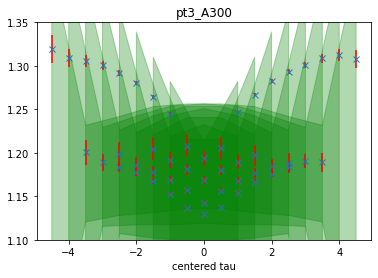

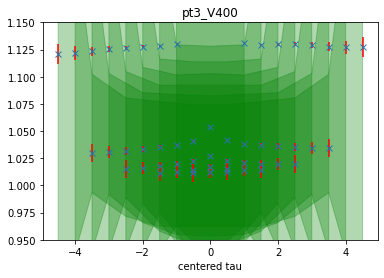

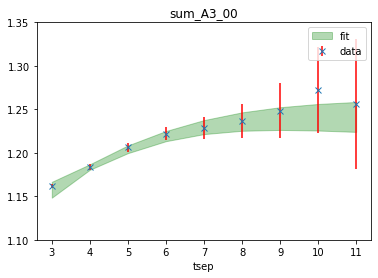

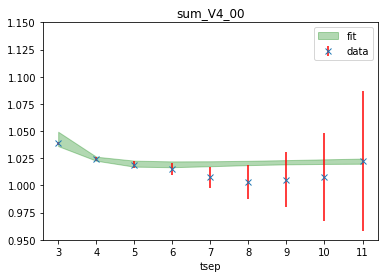

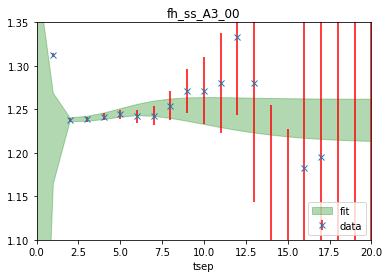

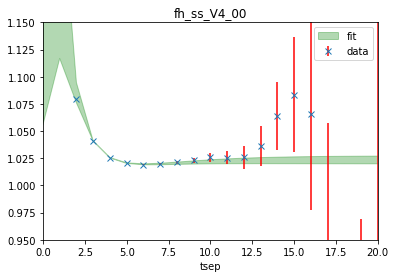

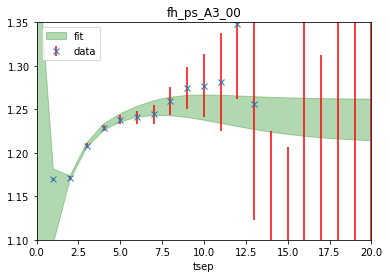

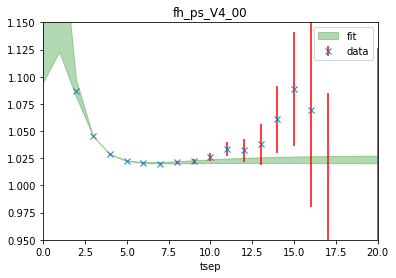

In [7]:
## Plot
E0 = 0.665
z0 = 0.000775
E1 = 1.045
z1 = 0.0005
E2 = 1.2
z2 = 0.0002


pt3_tau_cut = 1 # just control the plot range

plot = Plot(data_avg_dict, data_avg_dict_completed, pt2_data_range, pt3_data_range, pt3_tau_cut)

# plot data to estimate 
#plot.data_plot_E0(E0) # plot E0 and z0 with 2pt ss data
#plot.data_plot_E1(E0, z0, E1) # plot E1 and z1 with 2pt ss data
#plot.data_plot_E2(E0, z0, E1, z1, E2)
#plot.data_plot_E3(E0, z0, E1, z1, E2, z2)
#plot.data_plot_E0_ps(E0) # plot E0 and z0_ps with 2pt ps data
#plot.data_plot_fh() # plot dn with fh ss/ps data

# plot fit on the data
#plot.fit_plot_E0(best_fitter, best_result) # 2pt ss
#plot.fit_plot_E0_ps(best_fitter, best_result) # 2pt ps
plot.fit_plot_pt3(best_fitter, best_result) # 3pt
plot.fit_plot_sum(best_fitter, best_result) # sum sub
plot.fit_plot_fh_ss(best_fitter, best_result) # fh ss
plot.fit_plot_fh_ps(best_fitter, best_result) # fh ps

<font size=5 >Stability analysis</font>

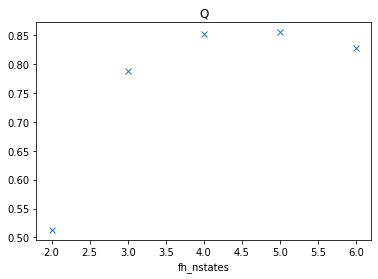

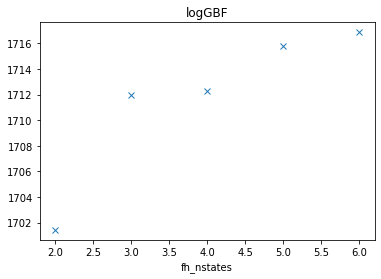

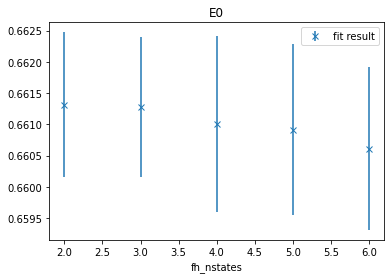

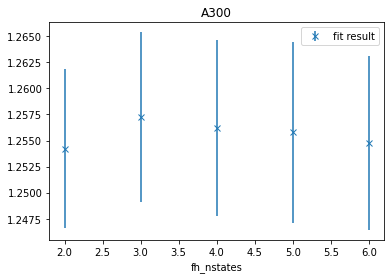

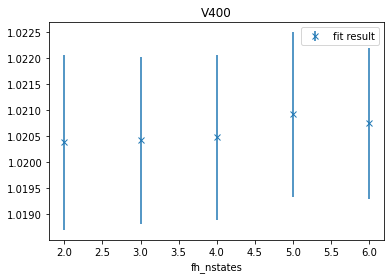

In [8]:
value={}
value['Q']=[]
value['logGBF']=[]
for key in ['E0', 'A3_over_V4', 'A300', 'V400']:
    value[key]=[]
    value[key+'_err']=[]

x=[]

for situation in formfactor_fit_T2K_fit.objects.filter(data_file_name='a12m310_a_avg.h5', prior_hexcode='8f93220b57b83c428e58ef5e4884e52e', include_2pt=True, include_2pt_ps=True, include_3pt=True, include_sum=True, include_fh_ss=True, include_fh_ps=True, machine_learning=False, pt2_tmin=3, pt2_tmax=12, pt2_nstates=7, pt2_ps_tmin=3, pt2_ps_tmax=12, pt3_A3_tsep_min=4, pt3_V4_tsep_min=4, pt3_A3_tsep_max=11, pt3_V4_tsep_max=11, pt3_tau_cut=1, pt3_nstates=5, sum_A3_tsep_min=4, sum_V4_tsep_min=4, sum_A3_tsep_max=11, sum_V4_tsep_max=11, sum_tau_cut=1, sum_nstates=2, fh_ss_A3_tsep_min=2, fh_ss_A3_tsep_max=11, fh_ss_V4_tsep_min=3, fh_ss_V4_tsep_max=13, fh_ps_A3_tsep_min=2, fh_ps_A3_tsep_max=11, fh_ps_V4_tsep_min=3, fh_ps_V4_tsep_max=13):
    if situation.fh_nstates != None:
        value['Q'].append(situation.Q_value)
        value['logGBF'].append(situation.log_GBF)
        value['E0'].append(situation.E0)
        value['E0_err'].append(situation.E0_err)
        value['A3_over_V4'].append(situation.A3_over_V4)
        value['A3_over_V4_err'].append(situation.A3_over_V4_err)
        value['A300'].append(situation.A300)
        value['A300_err'].append(situation.A300_err)
        value['V400'].append(situation.V400)
        value['V400_err'].append(situation.V400_err)
        x.append(situation.fh_nstates)  # here is the varying parameter

x_label = 'fh_nstates' # here is the varying parameter

plt.figure()
plt.plot(np.array(x), np.array(value['Q']), 'x')
plt.title('Q')
plt.xlabel(x_label)
#plt.ylim([0.4,0.5])
plt.savefig('./2'+x_label+'-Q.png')
plt.show()

plt.figure()
plt.plot(np.array(x), np.array(value['logGBF']), 'x')
plt.title('logGBF')
plt.xlabel(x_label)
#plt.savefig('./'+x_label+'-logGBF.png')
plt.show()

plt.figure()
plt.errorbar(np.array(x), np.array(value['E0']), yerr=np.array(value['E0_err']), fmt='x', label='fit result')
##plt.fill_between(np.array(x), upper * np.ones([len(np.array(x))]), lower * np.ones([len(np.array(x))]), color='g', alpha=0.3)
#plt.fill_between(np.array(x), (0.6572+0.0055) * np.ones([len(np.array(x))]), (0.6572-0.0055) * np.ones([len(np.array(x))]), color='g', alpha=0.3, label='best fit result') 
#plt.plot(np.array(x), 0.6572 * np.ones([len(np.array(x))]), 'r-') # central value of best fit result
plt.title('E0')
plt.xlabel(x_label)
plt.legend()
#plt.savefig('./2'+x_label+'-E0.png')
plt.show()

for key in ['A300', 'V400']: # 'A3_over_V4'    
    plt.figure()
    plt.errorbar(np.array(x), np.array(value[key]), yerr=np.array(value[key+'_err']), fmt='x', label='fit result')

    #if key == 'A300':
        #plt.fill_between(np.array(x), (1.229+0.039) * np.ones([len(np.array(x))]), (1.229-0.039) * np.ones([len(np.array(x))]), color='g', alpha=0.3, label='best fit result')
        #plt.plot(np.array(x), 1.229 * np.ones([len(np.array(x))]), 'r-') # central value of best fit result

    #elif key == 'V400':
        #plt.fill_between(np.array(x), (1.016+0.017) * np.ones([len(np.array(x))]), (1.016-0.017) * np.ones([len(np.array(x))]), color='g', alpha=0.3, label='best fit result')
        #plt.plot(np.array(x), 1.016 * np.ones([len(np.array(x))]), 'r-') # central value of best fit result

    plt.title(key)
    plt.xlabel(x_label)
    #plt.ylim([1.0, 1.03])
    #plt.savefig('./2'+x_label+'-'+key+'.png')
    plt.legend()
    plt.show()